*Last Modified*: March 3rd, 2023. [OI]

## Gravity Recovery and Climate Experiment (GRACE) thermospheric neutral density data derived via STAR (Space Three-axis Accelerometer for Research) accelerometer data. 
Downloaded from http://thermosphere.tudelft.nl/

##### References
[1] Masutti, D., March, G., Ridley, A. J., and Thoemel, J., “Effect of the solar activity variation on the Global Ionosphere Thermosphere Model (GITM)”, *Annales Geophysicae*, vol. 34, no. 9, pp. 725–736, 2016. doi:10.5194/angeo-34-725-2016.

##### Time period
The specific simulation windows have been selected in periods of low geomagnetic activity ($A_{p}$ < 30) in order to avoid any geomagnetic storm that could interfere with the study.

* Solar *Maximum* Cycle 23: 18/12/2001 $\to$ F10.7 $\approx 233$

* Solar *Minimum* Cycle 23: 24/10/2008 $\to$ F10.7 $\approx 66$

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np
from pandas import read_csv
import pandas as pd
import datetime as df
import astropy
from pymsis import msis
from astropy.coordinates import SkyCoord
from datetime import datetime, timedelta
from astropy.constants import R_earth
import astropy.units as u
from astropy import time

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 11}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=11) 
matplotlib.rc('ytick', labelsize=11) 

In [16]:
data = read_csv("data_grace/GA_DNS_ACC_2008_10_v02.txt", sep='\s+', on_bad_lines='skip')
data

,date,time,UTC/GPS,alt,lon,lat,lst,arglat,dens_x,dens_mean,flag,flag.1
0,2008-10-01,00:00:00.000,GPS,478005.041,-152.356,-4.743,14.011,184.674,1.048394e-13,7.409551e-14,0.0,0.0
1,2008-10-01,00:00:10.000,GPS,478206.007,-152.386,-5.384,14.011,185.311,1.053434e-13,7.408059e-14,0.0,0.0
2,2008-10-01,00:00:20.000,GPS,478410.057,-152.417,-6.025,14.012,185.948,1.055018e-13,7.406568e-14,0.0,0.0
3,2008-10-01,00:00:30.000,GPS,478617.151,-152.448,-6.665,14.013,186.584,1.050785e-13,7.405076e-14,0.0,0.0
4,2008-10-01,00:00:40.000,GPS,478827.247,-152.479,-7.306,14.014,187.221,1.067903e-13,7.403585e-14,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
266862,2008-10-31,23:59:10.000,GPS,482085.554,175.882,-70.820,11.981,250.690,1.826470e-13,1.103865e-13,0.0,0.0
266863,2008-10-31,23:59:20.000,GPS,482196.275,175.944,-71.455,11.988,251.329,1.846228e-13,1.103988e-13,0.0,0.0
266864,2008-10-31,23:59:30.000,GPS,482303.583,176.013,-72.090,11.995,251.968,1.825176e-13,1.104111e-13,0.0,0.0
266865,2008-10-31,23:59:40.000,GPS,482407.420,176.089,-72.724,12.003,252.606,1.767402e-13,1.104234e-13,0.0,0.0


In [6]:
data_timestamps = []

In [7]:
# save all timestamps in UTC. 
for ii in range(np.shape(data)[0]):
    # timestamp in GPS from chart. 
    GPS_timestamp = time.Time(str(data["date"][ii] + "T" + data["time"][ii])).gps
    GPS_time = time.Time(GPS_timestamp, format="gps")
    # convert to UTC [which is approx 12 seconds ahead].
    UTC_time = time.Time(GPS_time, format='iso',  scale='utc').value
    # add UTC timestamp to a list
    data_timestamps.append(pd.Timestamp(year=int(UTC_time[:4]), 
                                    month=int(UTC_time[5:7]), 
                                    day=int(UTC_time[8:10]),
                                    hour=int(UTC_time[11:13]), 
                                    minute=int(UTC_time[14:16]), 
                                    second=int(UTC_time[17:19]), 
                                    microsecond=int(UTC_time[20:])))

In [8]:
# coordinate transformation from geodetic to geocenteric
coords_geodetic = astropy.coordinates.EarthLocation.from_geodetic(lon=data["lon"]*u.deg, 
                                                         lat=data["lat"]*u.deg, 
                                                         height=data["alt"]*u.m, 
                                                         ellipsoid="GRS80")

x, y, z = coords_geodetic.geocentric

In [9]:
# descibe in spherical coordinates
coords_geocentric = astropy.coordinates.cartesian_to_spherical(x=x, y=y,z=z)
coords_geocentric

(<Distance [6855996.97912915, 6856156.20671281, 6856313.29899437, ...,
            6841092.80934319, 6841059.40994943, 6841026.60404719] m>,
 <Latitude [-0.08226776, -0.09338675, -0.10450602, ..., -1.25637595,
            -1.26749791, -1.27863828] rad>,
 <Longitude [3.62407147, 3.62354787, 3.62300682, ..., 3.07200638,
             3.07333283, 3.07483381] rad>)

### Considered time period 3 days of "spin off" and 1 day of simulation

In [34]:
max_timestamp = 210000
min_timestamp = 170000

In [35]:
print(data_timestamps[min_timestamp])
print(data_timestamps[max_timestamp])

2008-10-20 17:53:10
2008-10-25 10:02:10


### Intersection with San Diego

In [36]:
san_diego_lon, san_diego_lat = -117.1611, 32.7157

In [144]:
index_lon = np.where(np.abs(coords_geocentric[2].to(u.deg)[min_timestamp:max_timestamp]-180*u.deg - san_diego_lon*u.deg) < 3*u.deg)

In [145]:
index_lat = np.where(np.abs(coords_geocentric[1].to(u.deg)[min_timestamp:max_timestamp] - san_diego_lat*u.deg) < 2*u.deg)

In [146]:
index_intersect = np.intersect1d(index_lon, index_lat)

### Plot GRACE meassurements

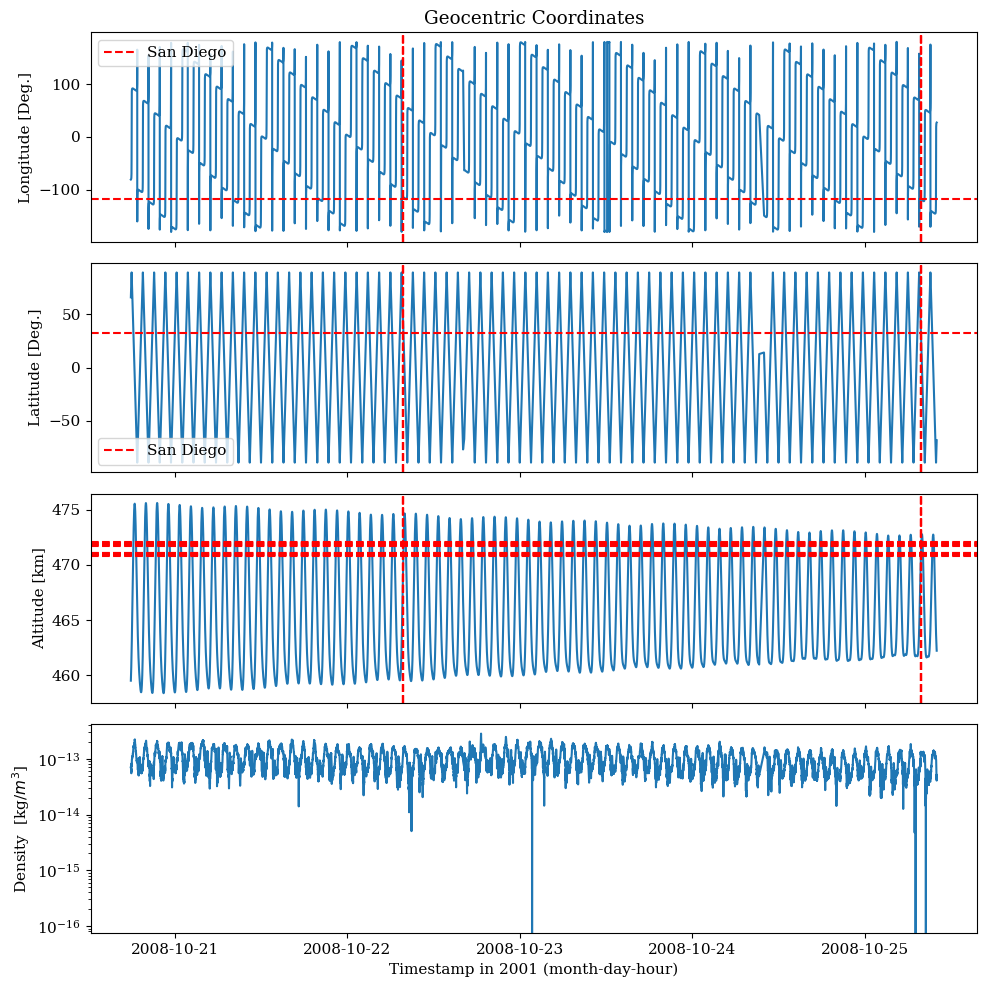

In [147]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(10, 10))
ax[0].plot(data_timestamps[min_timestamp :max_timestamp], coords_geocentric[2].to(u.deg)[min_timestamp :max_timestamp]-180*u.deg)
ax[0].axhline(san_diego_lon, c="r", ls="--", label="San Diego")
ax[0].set_ylabel("Longitude [Deg.]")
ax[1].plot(data_timestamps[min_timestamp :max_timestamp], coords_geocentric[1].to(u.deg)[min_timestamp :max_timestamp])
ax[1].set_ylabel("Latitude [Deg.]")
ax[1].axhline(san_diego_lat, c="r", ls="--", label="San Diego")
ax[2].plot(data_timestamps[min_timestamp :max_timestamp], (coords_geocentric[0] - R_earth).to(u.km)[min_timestamp :max_timestamp])
ax[2].set_ylabel("Altitude [km]")
ax[3].plot(data_timestamps[min_timestamp :max_timestamp], data["dens_x"][min_timestamp :max_timestamp])
ax[3].set_ylabel(r"Density  [kg/$m^3$]")
ax[0].set_title("Geocentric Coordinates")
ax[3].set_xlabel("Timestamp in 2001 (month-day-hour)")

for ii in index_intersect:
    ax[0].axvline(data_timestamps[min_timestamp + ii],c="r", ls="--")
    ax[1].axvline(data_timestamps[min_timestamp + ii],c="r", ls="--")
    ax[2].axvline(data_timestamps[min_timestamp + ii],c="r", ls="--")
    ax[2].axhline((coords_geocentric[0].to(u.m) - R_earth).to(u.km).value[min_timestamp + ii], c="r", ls="--")
    
_ = ax[0].legend()
_ = ax[1].legend()
_ = ax[3].set_yscale("log")
plt.tight_layout()
plt.savefig("figs/GRACE_location_and_observations_2008.png", dpi=600)

## Read in F10.7

In [41]:
f10p7_msis, f10p7a_msis, ap_msis = msis.get_f107_ap(dates=data_timestamps[min_timestamp:max_timestamp])

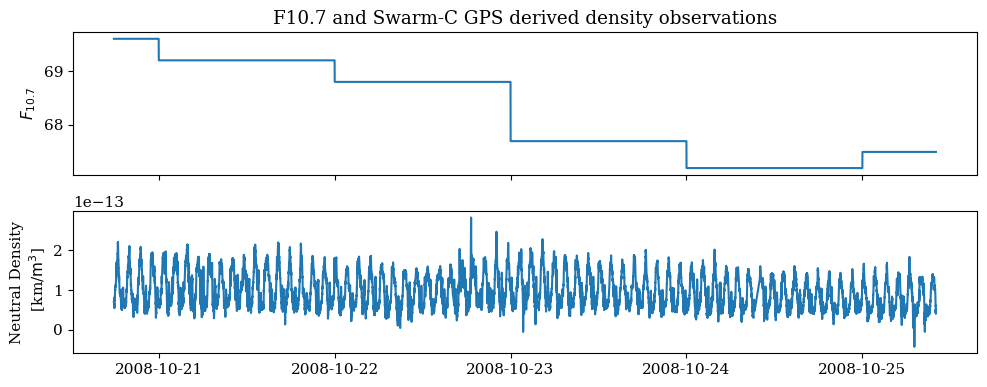

In [42]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 4))
ax[0].plot(data_timestamps[min_timestamp:max_timestamp], f10p7_msis, label="F10.7")
ax[1].plot(data_timestamps[min_timestamp:max_timestamp], data["dens_x"][min_timestamp:max_timestamp])
#ax[1].set_yscale("log")
ax[0].set_ylabel("$F_{10.7}$")
ax[0].set_title("F10.7 and Swarm-C GPS derived density observations")
#ax[0].legend()
_ = ax[1].set_ylabel("Neutral Density\n [km/$\mathrm{m}^3$]")
plt.tight_layout()
plt.savefig("figs/grace_meassurements_and_f10.7_2008.png", dpi=600)

## Read in 1D-GITM Results

In [68]:
cdir = os.getcwd()

In [69]:
fidelities = ["f3", "f4"]
parameters = []
mesh = []
pde = []
sol = []

In [104]:
for fidelity in fidelities:
    parameters.append(np.load(cdir[:-10] + "solutions_CHAMP_2008/" + str(fidelity) + "/parameters.npy", allow_pickle=True).item())
    pde.append(np.load(cdir[:-10] + "solutions_CHAMP_2008/" + str(fidelity) + "/pde.npy", allow_pickle=True).item())
    mesh.append(np.load(cdir[:-10] + "solutions_CHAMP_2008/" + str(fidelity) + "/mesh.npy", allow_pickle=True).item())
    sol.append(np.load(cdir[:-10] + "solutions_CHAMP_2008/" + str(fidelity) + "/sol.npy", allow_pickle=True))

In [105]:
# get dates
time_stamp_gitm = []
for ii in range(np.shape(sol[0])[-1]):
    time_stamp_gitm.append(datetime.strptime(parameters[0]["date"], '%Y-%m-%d %H:%M:%S') + timedelta(minutes=30)*ii)

In [111]:
phys_grid_fidelity = []

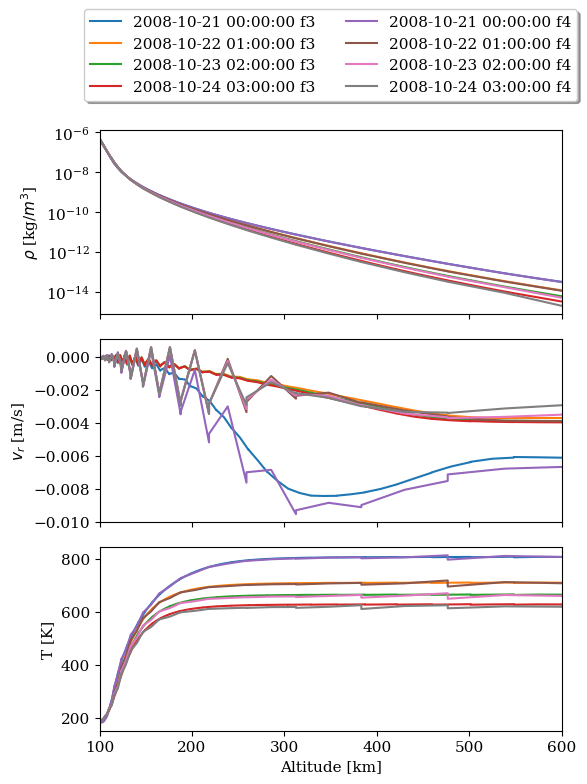

In [112]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6, 8))

for ii, fidelity in enumerate(fidelities):
    n_components, n_solution, n_resolution, n_timestamp = np.shape(sol[ii])
    # get parameters
    rho0 = pde[ii]["physicsparam"][19]
    H0 = pde[ii]["physicsparam"][17]
    T0 = pde[ii]["physicsparam"][18]
    # get grid 
    computational_grid = mesh[ii]["dgnodes"].flatten("F")
    phys_grid = ((computational_grid * float(H0) - R_earth.value) * u.m).to(u.km)
    phys_grid_fidelity.append(phys_grid)
    # plot 
    for jj in np.arange(0, n_timestamp, 50):
        # solution
        rho = np.exp(sol[ii][:, 0, :, jj]).flatten("F")
        vr = sol[ii][:, 1, :, jj].flatten("F") / np.sqrt(rho)
        T = sol[ii][:, 2, :, jj].flatten("F") / np.sqrt(rho)
        # plot solution
        ax[0].plot(phys_grid, rho*float(rho0), label=str(time_stamp_gitm[jj]) + " " + str(fidelity))
        ax[1].plot(phys_grid, vr)
        ax[2].plot(phys_grid, T*float(T0))
    
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.7), ncol=2, fancybox=True, shadow=True)
    ax[0].set_ylabel(r"$\rho$ [kg/$m^3$]")
    ax[1].set_ylabel(r"$v_{r}$ [m/s]")
    ax[2].set_ylabel(r"T [K]")

    ax[2].set_xlabel("Altitude [km]")
    ax[2].set_xticks([100, 200, 300, 400, 500, 600])
    ax[2].set_xlim(100, 600)
    ax[0].set_yscale("log")
    plt.tight_layout()
    plt.savefig("../figs/GITM_1D_results_f0.png", dpi=600)

In [126]:
print(np.argmin(np.abs(phys_grid_fidelity[0].to(u.km).value - 470))/n_components)
print(np.argmin(np.abs(phys_grid_fidelity[1].to(u.km).value - 470))/n_components)

27.333333333333332
13.666666666666666


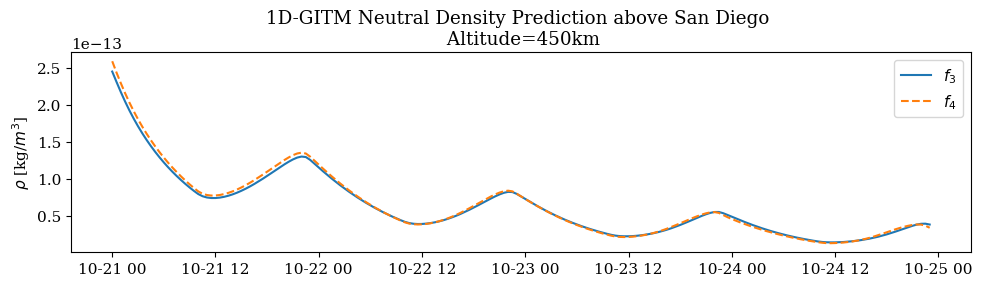

In [130]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(time_stamp_gitm,  np.exp(sol[0][1, 0, 27, :]).flatten("F")*float(rho0), label="$f_{3}$")
ax.plot(time_stamp_gitm,  np.exp(sol[1][2, 0, 13, :]).flatten("F")*float(rho0), ls="--", label="$f_{4}$")
ax.set_title("1D-GITM Neutral Density Prediction above San Diego \n Altitude=450km")
ax.set_ylabel(r"$\rho$ [kg/$m^3$]")
#ax.set_yscale("log")
ax.legend()
plt.tight_layout()
#plt.savefig("figs/1d_gitm_san_diego_400_altitude.png", dpi=400)